# Assignment based on Tutorial II: Fully connected NNs
<p>
AICP, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>
This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Test F: Two-Layer Model (Baseline) with Manually Expanded Dataset

Expanded dataset created by adding shifted and flipped copies


## 1. Load necessary libraries



In [1]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader 


## 2. Structure of a neural network

In [2]:
#Import nn.functional as F_nn to use neural network operations (e.g., softmax).
# Using an alias (F_nn) avoids confusion with image transformation functions from torchvision.

import torch.nn.functional as F_nn  # Alias for softmax and other neural network operations

#Class Definition and Initialization
class MyModel(nn.Module):
    def __init__(self, n_input, n_hiddens, n_output): 
        super(MyModel, self).__init__()
   
        self.ls = []
        n_prev = n_input
        for i, n_out in enumerate(n_hiddens):
          l = nn.Linear(n_prev, n_out) 
          n_prev = n_out 
          self.add_module(f'lin_{i}_{n_out}', l) 
          self.ls.append(l) 

        self.lout = nn.Linear(n_prev, n_output) 

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)       
        h = x 
        for li in self.ls:  
          h = li(h) 
          h = torch.relu(h) 
          
        logits = self.lout(h)
        probs = F.softmax(logits, dim=1) 
        pred = torch.argmax(probs, dim=1) 

        return logits, probs, pred
     

In [3]:
# Import the required image transformation functions from torchvision.
# Alias as F_tv to distinguish from nn.functional used elsewhere in the code.
from torchvision.transforms import functional as F_tv  
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a function to shift an image by a given number of pixels in the x and y directions.
def shift_image(image, shift_x, shift_y):
    return F_tv.affine(image, angle=0, translate=(shift_x, shift_y), scale=1, shear=0)

In [4]:
# Import the required image transformation functions from torchvision.
# Alias as F_tv to distinguish from nn.functional used elsewhere in the code.
from torchvision.transforms import functional as F_tv  
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a function to vertically flip an image.
def flip_image_vertically(image):
    return F_tv.vflip(image)  # Vertically flip the image


## 3. Load the data
First, we will load the data: originally, there are 60,000 training images and 10,000 images for validation. However, we will expand the training set by adding shifted copies of each image, which will increase the number of training images.

Each image is 28x28 pixels. For this model, we will interpret it as a 1D array of 784 elements.

Note: The images are initially 28x28 pixels, but since a neural network expects a flat array of features (a 1D vector), they will be transformed into a 1D array of 784 elements (28 × 28 = 784) within the model's forward method.

In [5]:
# Define a transform to normalize the data (no flattening here)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

# Load the original training dataset
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)

# Create an expanded dataset by adding shifted and flipped copies
expanded_dataset = []

for img, label in trainset:
    # Add the original image
    expanded_dataset.append((img, label))

    # Apply vertical flip and add the flipped image
    flipped_img = flip_image_vertically(img)
    expanded_dataset.append((flipped_img, label))

    # Shifts to create new copies: up, down, left, right
    shifts = [(2, 0), (-2, 0), (0, 2), (0, -2)] 

    for shift in shifts:
        # Apply the shift to the image
        shifted_img = shift_image(img, shift_x=shift[0], shift_y=shift[1])
        expanded_dataset.append((shifted_img, label))

# Convert the expanded dataset to a DataLoader for training
expanded_loader = DataLoader(expanded_dataset, batch_size=64, shuffle=True)

# Load the test dataset (no augmentation)
testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print the shapes of the datasets
print('Expanded train dataset shape:', len(expanded_dataset))
print('Test dataset shape:', len(testset))

Expanded train dataset shape: 360000
Test dataset shape: 10000


In [6]:
#Looping Over the Dataset
for el in trainset:
  x, y = el
  print(x.shape, y)
  break

torch.Size([1, 28, 28]) 9


In [7]:
for el in expanded_loader: # Use expanded_loader instead of trainloader
  x, y = el 
  print(x.shape, y.shape) 
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Adding this function with a Quick Inspection here, with purpose to visually confirm that the manually expanded images are appearing as intended before they are used in training.

torch.Size([64, 1, 28, 28]) torch.Size([64])


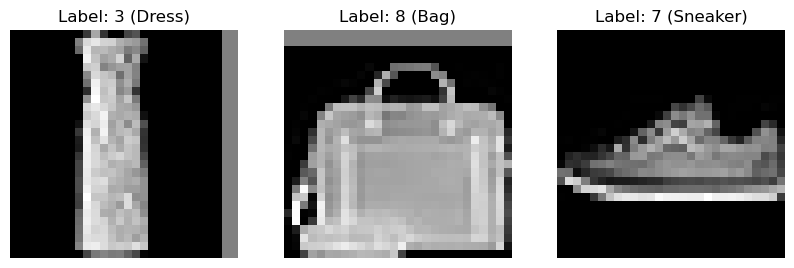

In [8]:
# Define the class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Quick inspection of augmented images
def quick_inspect(loader, num_images=3):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        # Display both the label index and the corresponding class name
        plt.title(f'Label: {labels[i].item()} ({class_names[labels[i].item()]})')
        plt.axis('off')
    plt.show()

# Print the shape of one batch from the expanded dataset
for el in expanded_loader:  # Use expanded_loader instead of trainloader
    x, y = el
    print(x.shape, y.shape)
    break

# Use the quick inspection function if needed
quick_inspect(expanded_loader)

## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [9]:
model = MyModel(n_input=784, n_hiddens=[1500], n_output=10)  

In [10]:
# Function to get the number of parameters
def get_npars(model):
    """
    Returns the total number of trainable parameters in the given PyTorch model.
    """
    n = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    return int(n)

# Get and print the number of parameters in the model
num_parameters = get_npars(model)
print(f'The model has {num_parameters} trainable parameters.')


The model has 1192510 trainable parameters.


In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Defining a training function:

In [12]:
def train(model, expanded_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in expanded_loader:
        optimizer.zero_grad()  
        output, _, _ = model(images) 
        loss = criterion(output, labels) 
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() 
    return running_loss / len(expanded_loader) 


Defining a testing function:

In [13]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    n_samples = 0  

    with torch.no_grad(): 
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels) 
            running_loss += loss.item()

            correct = torch.sum(pred == labels) 
            n_correct += correct.item()  
            n_samples += labels.size(0) 

    accuracy = n_correct / n_samples  # Compute overall accuracy
    return running_loss / len(testloader), accuracy

In [14]:
testloader.batch_size

64

Training the model

In [15]:
# Lists to store losses and accuracy for Test F model
train_losses_testF = []
test_losses_testF = []
test_accuracies_testF = []  

num_epochs = 10 # Number of epochs for training

for epoch in range(num_epochs):
    train_loss = train(model, expanded_loader, criterion, optimizer)
    test_loss, test_accuracy = test(model, testloader, criterion)  # Assuming test returns loss and accuracy

   # Store losses for Test F model
    train_losses_testF.append(train_loss)
    test_losses_testF.append(test_loss)

     # Store accuracy for Test F model
    test_accuracies_testF.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.4798, Test Loss: 0.4297, Test Accuracy: 0.8467
Epoch 2/10, Train Loss: 0.3797, Test Loss: 0.3923, Test Accuracy: 0.8603
Epoch 3/10, Train Loss: 0.3489, Test Loss: 0.3921, Test Accuracy: 0.8604
Epoch 4/10, Train Loss: 0.3309, Test Loss: 0.3673, Test Accuracy: 0.8726
Epoch 5/10, Train Loss: 0.3159, Test Loss: 0.3722, Test Accuracy: 0.8693
Epoch 6/10, Train Loss: 0.3044, Test Loss: 0.3646, Test Accuracy: 0.8746
Epoch 7/10, Train Loss: 0.2927, Test Loss: 0.3669, Test Accuracy: 0.8676
Epoch 8/10, Train Loss: 0.2847, Test Loss: 0.3629, Test Accuracy: 0.8748
Epoch 9/10, Train Loss: 0.2754, Test Loss: 0.3789, Test Accuracy: 0.8691
Epoch 10/10, Train Loss: 0.2690, Test Loss: 0.3714, Test Accuracy: 0.8748


Visualize the loss curves

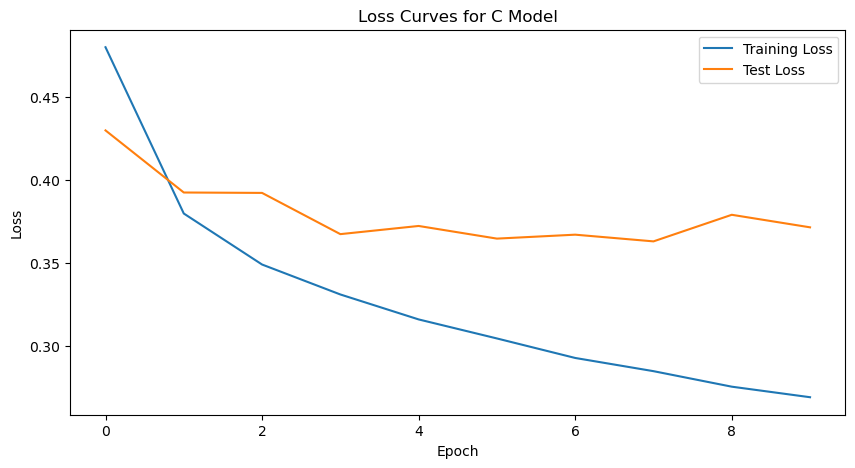

In [17]:
# Plotting the loss curves for the Test C model
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses_testF, label='Training Loss')
ax.plot(range(num_epochs), test_losses_testF, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.set_title('Loss Curves for C Model')
plt.show()

In [18]:
for p in model.parameters():
  print(np.prod(list(p.shape)))

1176000
1500
15000
10


In [19]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8748


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 0


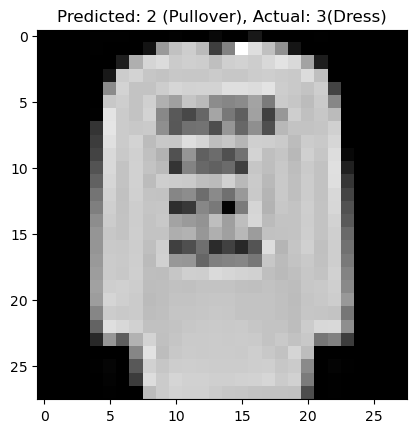

First correct digit is at index: 1


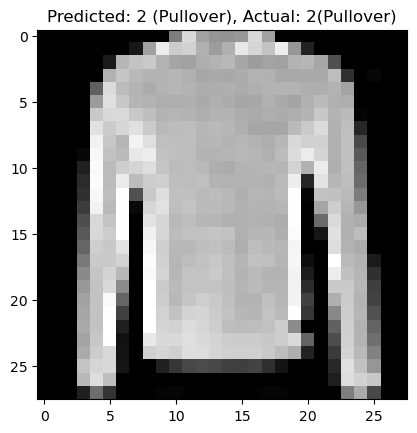

In [20]:
# Get the class names from the dataset
class_names = trainset.classes

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect sample (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    pred = predictions[wrong_idx]
    lbl  = labels[wrong_idx]
    display_image(images_list[wrong_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No incorrect predictions found")

# Display the first correct sample (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    pred = predictions[correct_idx]
    lbl  = labels[correct_idx]
    display_image(images_list[correct_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

torch.Size([10, 1500]) torch.Size([10])


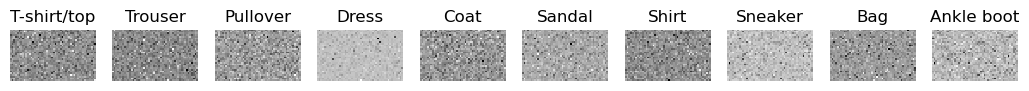

In [21]:
#inspecting and visualising the weights of the output layer
layer = model.lout 
n_features = layer.out_features 
w1, b1 = layer.weight.data, layer.bias.data #extract weights and biases from the output layer.
print(w1.shape, b1.shape) ## expecting w1 to be [n_features, 1500]

w1_reshaped = w1.view(n_features, 30, 50) #Adjust the view dimensions as per layer's configuration of 1500 neurons

# Plotting the weights
_, axs = plt.subplots(1, n_features, figsize=(13, 5))

for i in range(10): # Loop over the number of output features (classes)
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='gray', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title(f'{trainset.classes[i]}')
plt.show()

In [22]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, probs, pred = model(images)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy



In [23]:
#generate predictions and compute the final accuracy after training the model
predictions, labels, images_list = get_predictions(model, testloader)  
accuracy = calculate_accuracy(predictions, labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8748


In [25]:
import datetime

# Get the current date and time for unique naming
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the filename using only the test name (will overwrite with each run)
test_name = "testF"  # Replace with your test name
model_filename = f'{test_name}_trained_model.pth'

# Save the model and optimizer state dicts
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_losses_testF,
    'test_loss': test_losses_testF
}

torch.save(save_dict, model_filename)  # Add this line to actually save the dictionary
print(f'Trained model saved as {model_filename}')


Trained model saved as testF_trained_model.pth


In [26]:
# Code for Storing Results in JSON Files
import json

# Store the results (losses and accuracy) in a dictionary
results = {
    'train_losses': train_losses_testF,  
    'test_losses': test_losses_testF,    
    'test_accuracies': test_accuracies_testF, 
    'final_accuracy': accuracy  # Store the final accuracy calculated earlier
}

# Save results to a JSON file, overwrite each time
json_filename = f'{test_name}_results.json'  # No timestamp to allow overwriting
with open(json_filename, 'w') as f:
    json.dump(results, f)
print(f'Results saved in {json_filename}')


Results saved in testF_results.json
